# Data visualization and budget set up

import packages

In [2]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))

from configparser import ConfigParser
import matplotlib.pyplot as plt

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

In [3]:
pd.set_option('display.float_format', '{:.6f}'.format)


initial config file to config_dict

In [4]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/emea/June 2024 Update/config ups emea.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

05.22.2024


Query daily data

In [5]:
daily_df = GetBQData(training_query, _input, _output)
daily_df['month'] = daily_df.ds.dt.month
daily_df['year'] = daily_df.ds.dt.year


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [6]:
daily_df.ds.max()

Timestamp('2024-05-21 00:00:00')

In [7]:
daily_df.market.unique()

array(['Belgium', 'Czech', 'France', 'Germany', 'India', 'Ireland',
       'Italy', 'Netherlands', 'Poland', 'Saudi Arabia', 'Spain',
       'Sweden', 'Turkey', 'UAE', 'UK'], dtype=object)

In [8]:
pre_optimization_budget = daily_df[['year','X']].loc[(daily_df.month == 5) & (daily_df.year >= 2020)].groupby(['year']).sum().mean()


In [9]:
pre_optimization_budget

X   432876.386823
dtype: float64

In [10]:
df = daily_df.copy()
df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()


In [11]:
# remove rows without date or conversion quantity
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

df = df[df.ds < cutoff_month] # ensure data is only up to cutoff_point

In [12]:
small_market_str = 'SaudiArabia|UAE|Turkey|Ireland|Sweden|Netherlands|Belgium|Czech|Spain'
updated_df = Combine(df, 'L', small_market_str)
updated_df.market.unique()

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_countries_ori.loc[large_countries_ori[large_countries_ori['funnel'] == 'Generic'].index, 'generic_cost'] = large_countries_ori.loc[large_countries_ori['funnel'] == 'Generic', 'X']
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_countries_ori.loc[large_countries_ori[large_countries_ori['funnel'

array(['SM', 'France', 'Germany', 'Italy', 'Poland', 'UK', 'India'],
      dtype=object)

In [13]:
# Germany Non_Brand 2022 previous data 
updated_df.drop(updated_df[(updated_df.market == 'Germany') & (updated_df.funnel == 'Non_Brand') & (updated_df.ds <'2022-01-01')].index, inplace=True)

# France Non_Brand 2020-06 previous data 
updated_df.drop(updated_df[(updated_df.market == 'France') & (updated_df.funnel == 'Non_Brand') & (updated_df.ds <'2020-06-01')].index, inplace=True)


In [14]:
updated_df

,ds,region,market,account_type,funnel,Identifier,X,y,revenue,month,year,new_funnel,generic_cost,competitor_cost,generic_cost_split,competitor_cost_split,Weekend
0,2017-08-10,Europe,SM,-,-,S,1356.930006,228.000000,5158.681603,64.000000,16136.000000,BrandNon_BrandBrandBrandNon_BrandBrandNon_Bran...,NaN,NaN,0.500000,0.500000,0
1,2017-08-10,Europe,France,-,Brand,L,173.279994,173.000000,7054.282462,8.000000,2017.000000,NaN,0.000000,0.000000,0.500000,0.500000,0
3,2017-08-10,Europe,Germany,-,Brand,L,503.510001,654.000000,10945.736186,16.000000,4034.000000,NaN,0.000000,0.000000,0.500000,0.500000,0
5,2017-08-10,Europe,Italy,-,Brand,L,64.960001,117.000000,2945.112242,8.000000,2017.000000,NaN,0.000000,0.000000,0.500000,0.500000,0
6,2017-08-10,Europe,Italy,-,Non_Brand,L,510.899996,2.000000,50.343799,8.000000,2017.000000,NaN,510.899996,0.000000,1.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31832,2024-04-23,Europe,Poland,-,Non_Brand,L,210.370000,57.000000,1177.329977,16.000000,8096.000000,NaN,4.570000,205.800000,0.021724,0.978276,0
31833,2024-04-23,Europe,UK,-,Brand,L,5927.946900,1057.000000,24446.075943,8.000000,4048.000000,NaN,0.000000,0.000000,0.500000,0.500000,0
31834,2024-04-23,Europe,UK,-,Non_Brand,L,50.350000,17.000000,272.891697,16.000000,8096.000000,NaN,34.310000,16.040000,0.681430,0.318570,0
31835,2024-04-23,Europe,India,-,Brand,L,441.527800,193.000000,16368.877419,8.000000,4048.000000,NaN,0.000000,0.000000,0.500000,0.500000,0


In [54]:
df_filtered_plot = updated_df.loc[(updated_df['market']=='Italy')&(updated_df['funnel']=='Non_Brand')&(updated_df['ds']>='2020-06-01')].copy()
df_filtered_plot['year_month'] = df_filtered_plot.ds.dt.strftime('%Y-%m')
df_filtered_plot = df_filtered_plot.groupby(['market','year_month']).sum(numeric_only=True).reset_index()


In [55]:
df_filtered_plot.loc[df_filtered_plot['year_month']=='2024-03']

,market,year_month,X,y,revenue,month,year,generic_cost,competitor_cost,generic_cost_split,competitor_cost_split,Weekend
45,Italy,2024-03,2851.190200,914.000000,39458.077877,345.000000,232760.000000,1181.280200,1669.910000,9.482241,21.517759,10


In [56]:
# France Non_Brand
## High cost 2017-2018 low CQ 2017-2019
## decreasing trend in CQ 2020-2024 very low CQ in nov 2022. 
## High peaks in cost 2021-11 2023-12 2024-3. 
## remove data before 2020 -06 
# Germany Non_Brand
## decreasing trand in CQ 2022-2024, low trough in nov 2022


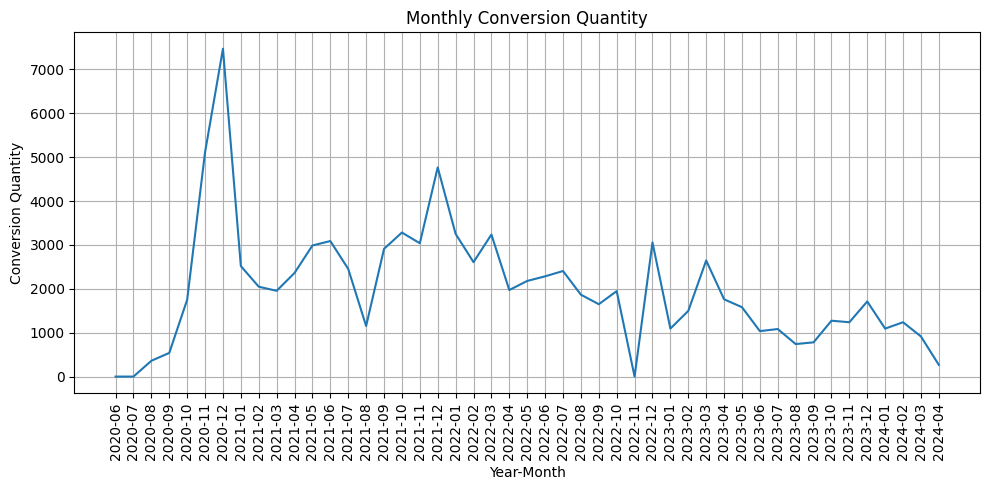

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['y'])  # Convert year_month to string for plotting
plt.title('Monthly Conversion Quantity')
plt.xlabel('Year-Month')
plt.ylabel('Conversion Quantity')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()


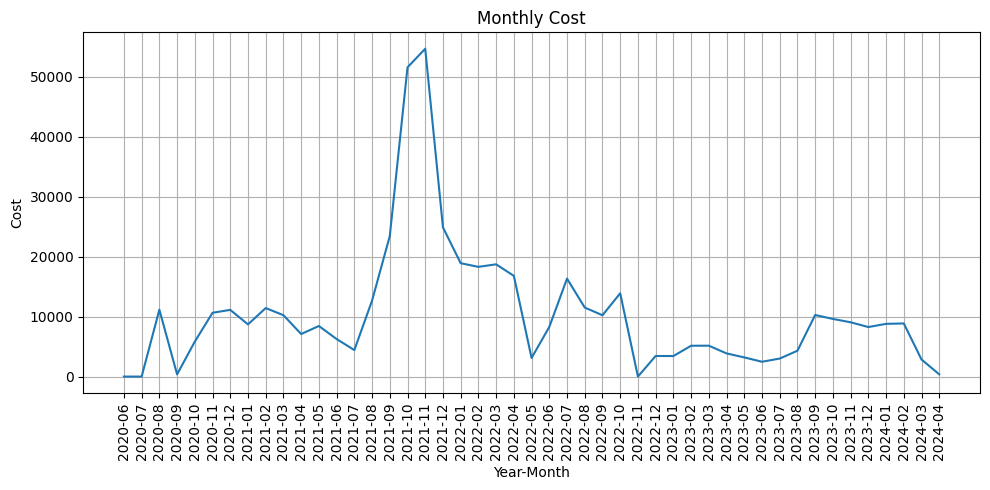

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['X'])  # Convert year_month to string for plotting
plt.title('Monthly Cost')
plt.xlabel('Year-Month')
plt.ylabel('Cost')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()


/var/tmp/ipykernel_31043/2729590374.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_filtered_plot['year_month'].astype(str), rotation=90)


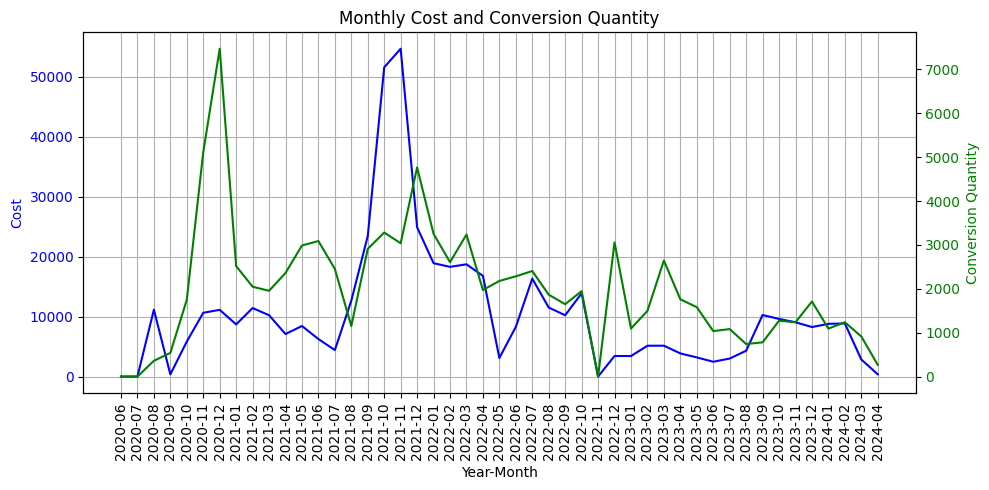

In [59]:

fig, ax1 = plt.subplots(figsize=(10, 5))


ax1.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['X'], color='b', label='Cost')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Cost', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Monthly Cost and Conversion Quantity')
ax1.grid(True)
ax1.set_xticklabels(df_filtered_plot['year_month'].astype(str), rotation=90)


ax2 = ax1.twinx()
ax2.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['y'], color='g', label='Conversion Quantity')
ax2.set_ylabel('Conversion Quantity', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.tight_layout()


plt.show()
